In [37]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
import labmate
from scipy.optimize import curve_fit

In [2]:
MHz = 1 * 2 * np.pi
GHz = 1e3 * MHz

# Fluxonium spectrum

In [3]:
N = 50

E_c = 0.47 * GHz
E_j = 4.3 * GHz
E_l = 0.17 * GHz

In [4]:
def flux_spec(phi_ext, Ec, Ej, El, N):
    a = qt.destroy(N)
    phi_zpf = (2 * Ec / El) ** 0.25
    n_zpf = 1.0 / (2 * phi_zpf)
    phi_op = phi_zpf * (a + a.dag())
    n_op = 1j * n_zpf * (a.dag() - a)
    H_harm = 4.0 * Ec * (n_op**2) + 0.5 * El * (phi_op**2)
    H_josep = -Ej * (phi_op - phi_ext).cosm()
    H = H_harm + H_josep
    return H.eigenenergies()


In [5]:
phi_exts = np.linspace(-1, 1, 51) * np.pi / 8 + np.pi
flux_specs = np.array([flux_spec(phi_ext, E_c, E_j, E_l, N) for phi_ext in phi_exts])

/Users/remirousseau/.pyenv/versions/3.13.0/envs/dynamiqs/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/remirousseau/.pyenv/versions/3.13.0/envs/dynamiqs/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


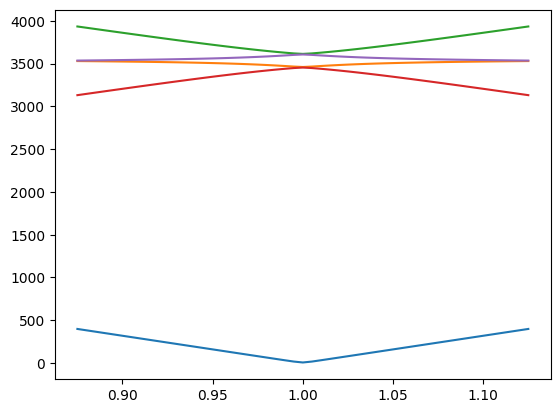

In [6]:
for i in range(2):
    for j in range(i, 4):
        if i == j:
            continue
        delta = flux_specs[:, j] - flux_specs[:, i]
        plt.plot(phi_exts / np.pi, delta / MHz)

# Spurious mode

In [7]:
Nf, Ns = 100, 2

E_c = 0.47 * GHz
E_j = 4.3 * GHz
E_l = 0.17 * GHz

omega_spur = 3.7 * GHz
g_spur = 0.2 * GHz

In [82]:
def flux_spec_spur(phi_ext, Ec, Ej, El, omega_spur, g_spur, Nf, Ns):
    a = qt.tensor(qt.destroy(Nf), qt.identity(Ns))
    b = qt.tensor(qt.identity(Nf), qt.destroy(Ns))

    phi_zpf = (2 * Ec / El) ** 0.25
    n_zpf = 1.0 / (2 * phi_zpf)
    phi_op = phi_zpf * (a + a.dag())
    n_op = 1j * n_zpf * (a.dag() - a)
    H_harm = 4.0 * Ec * (n_op**2) + 0.5 * El * (phi_op**2)
    H_josep = -Ej * (phi_op - phi_ext).cosm()
    H = H_harm + H_josep

    H += omega_spur * b.dag() * b
    H += g_spur * (b.dag() + b) * 1j * (a.dag() - a)
    return H.eigenenergies().real


In [9]:
phi_exts = np.linspace(-1, 1, 31) * np.pi / 4 + np.pi
flux_specs_spur = []
for phi_ext in tqdm(phi_exts):
    flux_specs_spur.append(
        flux_spec_spur(phi_ext, E_c, E_j, E_l, omega_spur, g_spur, Nf, Ns)
    )
flux_specs_spur = np.array(flux_specs_spur)

100%|██████████| 31/31 [00:02<00:00, 14.76it/s]


(3900.0, 4100.0)

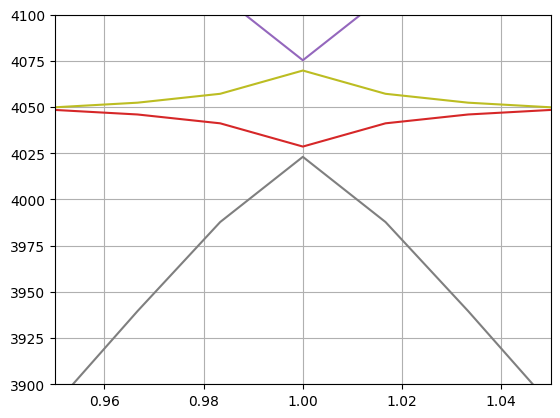

In [10]:
for i in range(2):
    for j in range(i, 6):
        if i == j:
            continue
        delta = flux_specs_spur[:, j] - flux_specs_spur[:, i]
        plt.plot(phi_exts / np.pi, delta / MHz)
plt.grid()
plt.xlim(0.95, 1.05)
plt.ylim(3900, 4100)

# Gathering data and hand fitting

In [11]:
data1 = labmate.AnalysisData(
    "data/2025_04_25__16_23_23__schuster_stark_prepare_vs_flux.h5"
)
data2 = labmate.AnalysisData(
    "data/2025_04_27__22_10_47__schuster_stark_prepare_vs_flux.h5"
)

In [12]:
def plot_all(phi_exts=None, flux_specs_spur=None):
    second_plot = phi_exts is not None and flux_specs_spur is not None
    fig = plt.figure(figsize=(6 * (1 + second_plot), 8))
    grid = plt.GridSpec(2, 1 + second_plot, figure=fig)
    axs = []
    for g, data in zip([grid[0, 0], grid[1, 0]], [data1, data2]):
        a = fig.add_subplot(g)
        a.imshow(
            data.left[:, :, 0],
            origin="lower",
            aspect="auto",
            extent=(
                data.voltages[0],
                data.voltages[-1],
                data.schuster1_freqs[0] * 1e-9,
                data.schuster1_freqs[-1] * 1e-9,
            ),
        )
        a.set_ylim(data.schuster1_freqs[0] * 1e-9, data.schuster1_freqs[-1] * 1e-9)
        a.set_xlim(data.voltages[0], data.voltages[-1])
        axs.append(a)
    if not second_plot:
        return
    axs.append(fig.add_subplot(grid[:, 1]))
    for a in axs:
        if a == axs[2]:
            kwargs = {}
        else:
            kwargs = {"c": "r", "ls": "--"}
        for i in range(2):
            for j in range(i, 6):
                if i == j:
                    continue
                delta = flux_specs_spur[:, j] - flux_specs_spur[:, i]
                a.plot(phi_exts - np.pi, delta / GHz, **kwargs)
        a.set_xlabel("Flux (rad)")
        a.set_ylabel("Frequency (GHz)")
    axs[2].set_ylim(3, 5)
    for d in [data1, data2]:
        for ind in [-1, 0]:
            axs[2].axhline(d.schuster1_freqs[ind] * 1e-9, color="k", ls="--")
    print(np.min(flux_specs_spur[:, 1] - flux_specs_spur[:, 0]) / MHz, "MHz")

100%|██████████| 21/21 [00:01<00:00, 15.19it/s]

1.6698704318915898 MHz


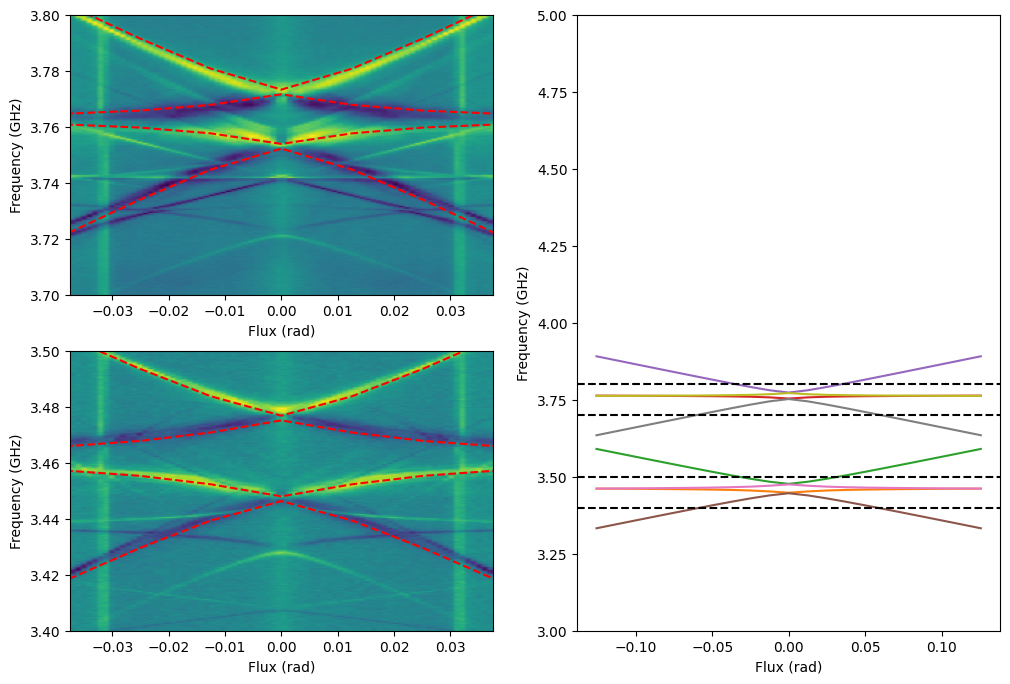

In [13]:
ej_t_ec = (1.407 * GHz) ** 2
ej_o_ec = 12.5
# E_c = 0.39 * GHz
# E_j = 4.94 * GHz
E_c = np.sqrt(ej_t_ec / ej_o_ec)
E_j = np.sqrt(ej_t_ec * ej_o_ec)
E_l = 0.17 * GHz
omega_spur = 3.637 * GHz
g_spur = 0.067 * GHz

phi_exts = np.linspace(-1, 1, 21) * 0.04 * np.pi + np.pi
flux_specs_spur = []
for phi_ext in tqdm(phi_exts):
    flux_specs_spur.append(
        flux_spec_spur(phi_ext, E_c, E_j, E_l, omega_spur, g_spur, Nf, Ns)
    )
flux_specs_spur = np.array(flux_specs_spur)

plot_all(phi_exts, flux_specs_spur)

# Real fitting

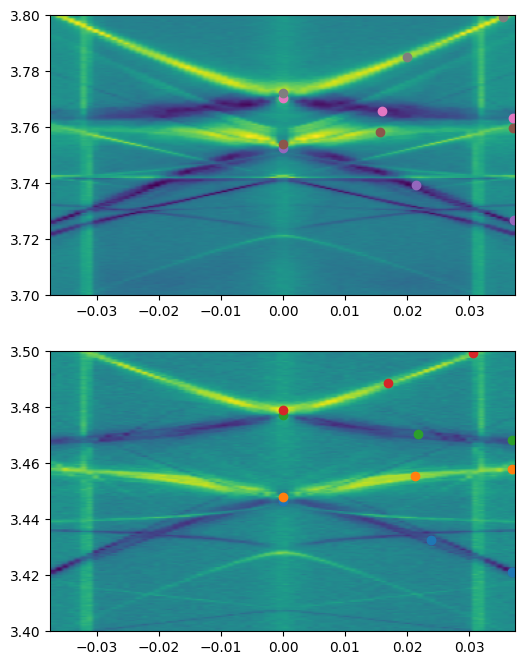

In [125]:
xs = [
    [0.037, 0.02395, 0],
    [0.037, 0.02137, 0],
    [0.037, 0.02185, 0],
    [0.03073, 0.01702, 0],
    [0.03734, 0.02153, 0],
    [0.03718, 0.01573, 0],
    [0.03718, 0.01605, 0],
    [0.03556, 0.02008, 0],
]
ys = [
    [3.4212, 3.4325, 3.44645],
    [3.4579, 3.4554, 3.4479],
    [3.4682, 3.4704, 3.4771],
    [3.4993, 3.4886, 3.4789],
    [3.7268, 3.7393, 3.7525],
    [3.7596, 3.7582, 3.7539],
    [3.7632, 3.7657, 3.7704],
    [3.7993, 3.785, 3.7721],
]
plot_all()
fig = plt.gcf()
for a in fig.axes:
    for x, y in zip(xs, ys):
        a.plot(x, y, "o")

In [127]:
xs = [
    [0],
    [0.037, 0.02395, 0],
    [0.037, 0.02137, 0],
    [0.037, 0.02185, 0],
    [0.03073, 0.01702, 0],
    [0.03734, 0.02153, 0],
    [0.03718, 0.01573, 0],
    [0.03718, 0.01605, 0],
    [0.03556, 0.02008, 0],
]
ys = [
    [2.4e-3],
    [3.4212, 3.4325, 3.44645],
    [3.4579, 3.4554, 3.4479],
    [3.4682, 3.4704, 3.4771],
    [3.4993, 3.4886, 3.4789],
    [3.7268, 3.7393, 3.7525],
    [3.7596, 3.7582, 3.7539],
    [3.7632, 3.7657, 3.7704],
    [3.7993, 3.785, 3.7721],
]
N_per_curve = len(xs[1])


def fit_function(phi_exts, E_c, E_j, E_l, omega_spur, g_spur):
    Nf, Ns = 100, 5
    res_freqs = []
    for phi_ext in tqdm(phi_exts):
        res_freqs.append(
            flux_spec_spur(phi_ext + np.pi, E_c, E_j, E_l, omega_spur, g_spur, Nf, Ns)
        )
    res_freqs = np.array(res_freqs)
    results = [[res_freqs[0, 1] - res_freqs[0, 0]]]
    res_freqs = res_freqs[1:]
    for i, (ind0, ind1) in enumerate(
        zip([1, 0, 1, 0, 1, 0, 1, 0], [2, 2, 3, 3, 4, 4, 5, 5])
    ):
        results.append(
            res_freqs[i * N_per_curve : (i + 1) * N_per_curve, ind1]
            - res_freqs[i * N_per_curve : (i + 1) * N_per_curve, ind0]
        )
    return np.concatenate(results) / GHz

In [128]:
guess = 0.3979 * GHz, 4.9745 * GHz, 0.17 * GHz, 3.637 * GHz, 67 * MHz
guess_freqs = fit_function(np.concatenate(xs), *guess)

100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


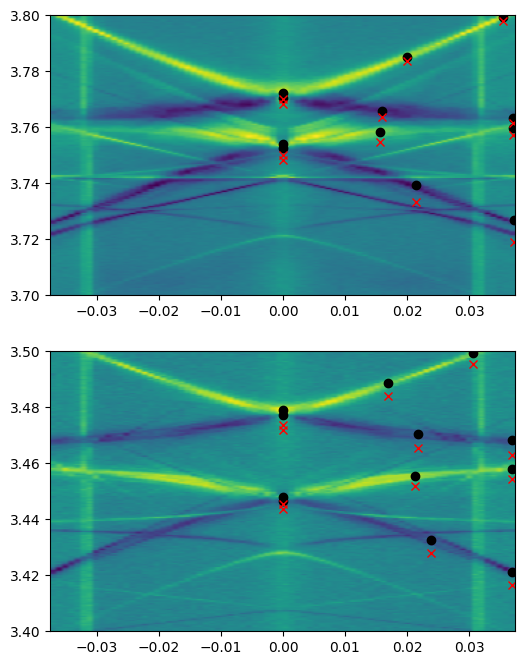

In [129]:
plot_all()
fig = plt.gcf()
for a in fig.axes:
    for x, y in zip(xs, ys):
        a.plot(x, y, "ko")
    a.set_prop_cycle(None)
    for x, y in zip(xs[1:], (guess_freqs[1:]).reshape(-1, 3)):
        a.plot(x, y, "rx")

In [130]:
popt, pcov = curve_fit(fit_function, np.concatenate(xs), np.concatenate(ys), p0=guess)

100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


100%|██████████| 51/51 [00:28<00:00,  1.81it/s]

1.6885699806464034 MHz


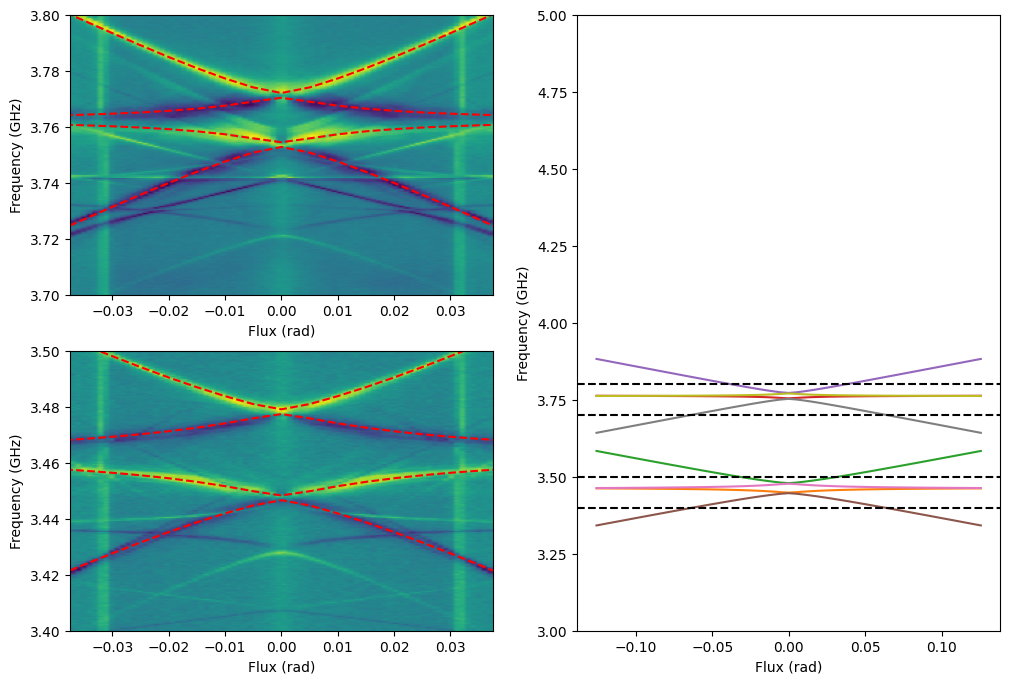

In [132]:
phi_exts = np.linspace(-1, 1, 51) * 0.04 * np.pi + np.pi
flux_specs_spur = []
for phi_ext in tqdm(phi_exts):
    flux_specs_spur.append(flux_spec_spur(phi_ext, *popt, 110, 5))
flux_specs_spur = np.array(flux_specs_spur)

plot_all(phi_exts, flux_specs_spur)

# Maybe its a second order transition

In [133]:
def plot_all_2(phi_exts=None, flux_specs_spur=None):
    second_plot = phi_exts is not None and flux_specs_spur is not None
    fig = plt.figure(figsize=(6 * (1 + second_plot), 8))
    grid = plt.GridSpec(2, 1 + second_plot, figure=fig)
    axs = []
    for g, data in zip([grid[0, 0], grid[1, 0]], [data1, data2]):
        a = fig.add_subplot(g)
        a.imshow(
            data.left[:, :, 0],
            origin="lower",
            aspect="auto",
            extent=(
                data.voltages[0],
                data.voltages[-1],
                data.schuster1_freqs[0] * 1e-9,
                data.schuster1_freqs[-1] * 1e-9,
            ),
        )
        a.set_ylim(data.schuster1_freqs[0] * 1e-9, data.schuster1_freqs[-1] * 1e-9)
        a.set_xlim(data.voltages[0], data.voltages[-1])
        axs.append(a)
    if not second_plot:
        return
    axs.append(fig.add_subplot(grid[:, 1]))
    for a in axs:
        for i in range(2):
            for j in range(i, 14):
                if a == axs[2]:
                    kwargs = {}
                else:
                    kwargs = {"c": "r", "ls": "--"}
                if i == j:
                    continue
                delta = flux_specs_spur[:, j] - flux_specs_spur[:, i]
                if j >= 8:
                    delta = delta / 2
                    kwargs["ls"] = ":"
                a.plot(phi_exts - np.pi, delta / GHz, **kwargs)
        a.set_xlabel("Flux (rad)")
        a.set_ylabel("Frequency (GHz)")
    axs[2].set_ylim(3, 5)
    for d in [data1, data2]:
        for ind in [-1, 0]:
            axs[2].axhline(d.schuster1_freqs[ind] * 1e-9, color="k", ls="--")
    print(np.min(flux_specs_spur[:, 1] - flux_specs_spur[:, 0]) / MHz, "MHz")

100%|██████████| 41/41 [00:06<00:00,  6.42it/s]


1.688554336958762 MHz


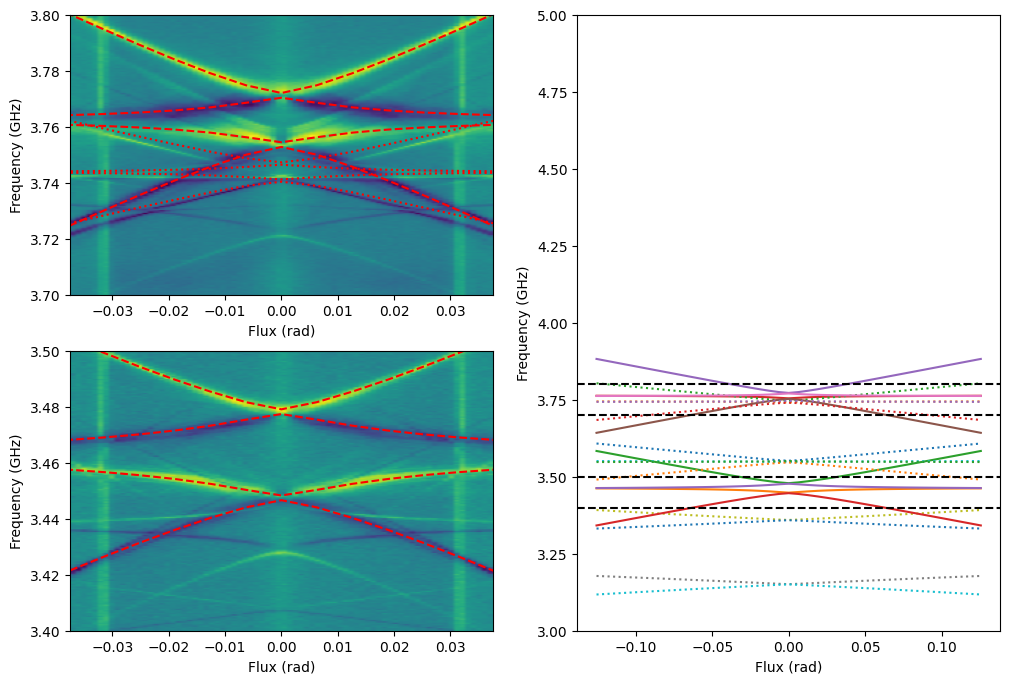

In [134]:
Nf, Ns = 70, 4

E_c = popt[0]
E_j = popt[1]
E_l = popt[2]
omega_spur = popt[3]
g_spur = popt[4]

phi_exts = np.linspace(-1, 1, 41) * 0.04 * np.pi + np.pi
flux_specs_spur = []
for phi_ext in tqdm(phi_exts):
    flux_specs_spur.append(
        flux_spec_spur(phi_ext, E_c, E_j, E_l, omega_spur, g_spur, Nf, Ns)
    )
flux_specs_spur = np.array(flux_specs_spur)

plot_all_2(phi_exts, flux_specs_spur)

In [137]:
popt / GHz

array([0.39985564, 4.93770627, 0.15863776, 3.65423311, 0.06447704])